In [1]:
# 加载数据
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
# 参数与配置
torch.manual_seed(100)  # 设置随机种子，以使实验结果具有可重复性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载数据集
def dataloader(batch_size, workers=2):
    # 训练集
    train_set = load('../dataresult/train_set')
    train_label = load('../dataresult/train_label')
    # 测试集
    test_set = load('../dataresult/test_set')
    test_label = load('../dataresult/test_label')

    # 加载数据
    train_loader = Data.DataLoader(dataset=Data.TensorDataset(train_set, train_label),
                                   batch_size=batch_size, num_workers=workers, drop_last=True)
    test_loader = Data.DataLoader(dataset=Data.TensorDataset(test_set, test_label),
                                  batch_size=batch_size, num_workers=workers, drop_last=True)
    return train_loader, test_loader

batch_size = 32
# 加载数据
train_loader, test_loader = dataloader(batch_size)

print(len(train_loader))
print(len(test_loader))

114
73


In [2]:
import torch
import torch.nn as nn
import math

def kernel_size(in_channel): #计算一维卷积的核大小，利用的是ECA注意力中的参数[动态卷积核]
    k = int((math.log2(in_channel) + 1) // 2)
    return k + 1 if k % 2 == 0 else k

class MultiScaleFeatureExtractor(nn.Module): #多尺度特征提取器[对T1和T2不同时刻的特征进入到不同尺寸的卷积核加强提取]

    def __init__(self, in_channel, out_channel):
        super().__init__()
        # 使用不同尺寸的卷积核进行特征提取
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channel, out_channel, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channel, out_channel, kernel_size=7, padding=3)
        self.relu = nn.ReLU()

    def forward(self, x):
        # 分别使用不同尺寸的卷积核进行卷积操作
        out1 = self.relu(self.conv1(x))
        out2 = self.relu(self.conv2(x))
        out3 = self.relu(self.conv3(x))
        out = out1 + out2 + out3  # 将不同尺度的特征相加
        return out

class ChannelAttention(nn.Module):

    def __init__(self, in_channel):
        super().__init__()
        # 使用自适应平均池化和最大池化提取全局信息
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.k = kernel_size(in_channel)
        # 使用一维卷积计算通道注意力
        self.channel_conv1 = nn.Conv1d(4, 1, kernel_size=self.k, padding=self.k // 2)
        self.channel_conv2 = nn.Conv1d(4, 1, kernel_size=self.k, padding=self.k // 2)
        self.softmax = nn.Softmax(dim=0)

    def forward(self, t1, t2):
        # 对 t1 和 t2 进行平均池化和最大池化
        t1_channel_avg_pool = self.avg_pool(t1)
        t1_channel_max_pool = self.max_pool(t1)
        t2_channel_avg_pool = self.avg_pool(t2)
        t2_channel_max_pool = self.max_pool(t2)
        # 将池化结果拼接并转换维度
        channel_pool = torch.cat([
            t1_channel_avg_pool, t1_channel_max_pool,
            t2_channel_avg_pool, t2_channel_max_pool
        ], dim=2).squeeze(-1).transpose(1, 2)
        # 使用一维卷积计算通道注意力
        t1_channel_attention = self.channel_conv1(channel_pool)
        t2_channel_attention = self.channel_conv2(channel_pool)
        # 堆叠并使用Softmax进行归一化
        channel_stack = torch.stack([t1_channel_attention, t2_channel_attention], dim=0)
        channel_stack = self.softmax(channel_stack).transpose(-1, -2).unsqueeze(-1)
        return channel_stack


class SpatialAttention(nn.Module):
    def __init__(self):
        super().__init__()
        # 使用二维卷积计算空间注意力
        self.spatial_conv1 = nn.Conv2d(4, 1, kernel_size=7, padding=3)
        self.spatial_conv2 = nn.Conv2d(4, 1, kernel_size=7, padding=3)
        self.softmax = nn.Softmax(dim=0)

    def forward(self, t1, t2):
        # 计算 t1 和 t2 的平均值和最大值
        t1_spatial_avg_pool = torch.mean(t1, dim=1, keepdim=True)
        t1_spatial_max_pool = torch.max(t1, dim=1, keepdim=True)[0]
        t2_spatial_avg_pool = torch.mean(t2, dim=1, keepdim=True)
        t2_spatial_max_pool = torch.max(t2, dim=1, keepdim=True)[0]
        # 将平均值和最大值拼接
        spatial_pool = torch.cat([
            t1_spatial_avg_pool, t1_spatial_max_pool,
            t2_spatial_avg_pool, t2_spatial_max_pool
        ], dim=1)
        # 使用二维卷积计算空间注意力
        t1_spatial_attention = self.spatial_conv1(spatial_pool)
        t2_spatial_attention = self.spatial_conv2(spatial_pool)
        # 堆叠并使用Softmax进行归一化
        spatial_stack = torch.stack([t1_spatial_attention, t2_spatial_attention], dim=0)
        spatial_stack = self.softmax(spatial_stack)
        return spatial_stack

class TFAM(nn.Module):
    """时序融合注意力模块"""

    def __init__(self, in_channel):
        super().__init__()
        self.channel_attention = ChannelAttention(in_channel)
        self.spatial_attention = SpatialAttention()
        
    def forward(self, t1, t2):
        # 计算通道和空间注意力
        channel_stack = self.channel_attention(t1, t2)
        spatial_stack = self.spatial_attention(t1, t2)
        # 加权相加并进行融合
        stack_attention = channel_stack + spatial_stack + 1
        fuse = stack_attention[0] * t1 + stack_attention[1] * t2
        return fuse

class BFM(nn.Module):
    def __init__(self, in_channel):
        super().__init__()
        self.multi_scale_extractor = MultiScaleFeatureExtractor(in_channel, in_channel)
        self.tfam = TFAM(in_channel)

    def forward(self, t1, t2):
        # 进行多尺度特征提取
        t1_multi_scale = self.multi_scale_extractor(t1)
        t2_multi_scale = self.multi_scale_extractor(t2)
        # 使用TFAM进行融合
        output = self.tfam(t1_multi_scale, t2_multi_scale)
        return output

In [3]:
from torch.nn import Transformer, TransformerEncoder, TransformerEncoderLayer
# 定义 CNNTransformer 模型
class CNNTransformer(nn.Module):
    def __init__(self, input_dim, conv_archs, hidden_dim, num_layers, num_heads, output_dim, dropout_rate=0.5):
        """
        params:
        input_dim          : 输入数据的维度
        conv_archs         : cnn 网络结构
        hidden_dim         : 注意力维度
        num_layers         : Transformer编码器层数
        num_heads          : 多头注意力头数
        output_dim         : 输出维度
        dropout_rate        : 随机丢弃神经元的概率
        """
        super().__init__()
        # 参数
        self.output_dim = output_dim

        # CNN参数
        self.conv_arch = conv_archs # cnn网络结构
        self.input_channels = input_dim # 输入通道数
        self.cnn_features = self.make_layers()

        # Transformer编码器
        self.hidden_dim = hidden_dim
        # Time Transformer layers
        self.transformer = TransformerEncoder(
            TransformerEncoderLayer(conv_archs[-1][-1], num_heads, hidden_dim, dropout=dropout_rate, batch_first=True),
            num_layers
        )

        # # 定义 BFMAttention
        self.bfm = BFM(conv_archs[-1][-1])

        # 序列平局池化
        self.avgpool = nn.AdaptiveAvgPool1d(1)

        # 定义线性层
        self.linear  = nn.Linear(conv_archs[-1][-1], output_dim)

      # CNN卷积池化结构
    def make_layers(self):
        layers = []
        for (num_convs, out_channels) in self.conv_arch:
            for _ in range(num_convs):
                layers.append(nn.Conv1d(self.input_channels, out_channels, kernel_size=3, padding=1))
                layers.append(nn.ReLU(inplace=True))
                self.input_channels = out_channels
            # layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        return nn.Sequential(*layers)

    def forward(self, input_seq):
        batch_size = input_seq.size(0)
        # CNN 卷积池化
        # CNN 网络输入[batch,H_in, seq_length]
        # 调换维度[B, L, D] --> [B, D, L]
        input_seq = input_seq.permute(0,2,1)
        cnn_features = self.cnn_features(input_seq) # torch.Size([32, 32, 1])
        # print(cnn_features.size())
        
        # 调换维度[B, D, L] --> [B, L, D]
        cnn_features = cnn_features.permute(0,2,1)

        # Time-Transformer 处理
        # 在PyTorch中，transformer模型的性能与batch_first参数的设置相关。
        # 当batch_first为True时，输入的形状应为(batch, sequence, feature)，这种设置在某些情况下可以提高推理性能。
        transformer_output = self.transformer(cnn_features)  #  torch.Size([32, 1, 32])

        # ---------- BFＭ 融合开始 ----------
        # T1 = Transformer 输出，T2 = CNN 输出
        t1 = transformer_output.permute(0, 2, 1).unsqueeze(-1)   # [B, C, L, 1]  ★
        t2 = cnn_features.permute(0, 2, 1).unsqueeze(-1)         # [B, C, L, 1]  ★
        bfm_out = self.bfm(t1, t2)                               # [B, C, L, 1]  ★
        transformer_output = bfm_out.squeeze(-1).permute(0, 2, 1)  # 还原成 [B, L, C] ★
        # ---------- BFＭ 融合结束 ----------



        # 序列平均池化操作
        output_avgpool = self.avgpool(transformer_output.transpose(1, 2))  #  torch.Size([32, 32, 1])
        output_avgpool = output_avgpool.reshape(batch_size, -1)  #  torch.Size([32, 32])
        predict = self.linear(output_avgpool) 
        return predict

In [4]:
# 定义模型参数
input_dim = 14    # 输入维度为 14 个维度
conv_archs = ((1, 32),)   # CNN 层卷积池化结构  类似VGG
output_dim = 1   # 输出维度 为1
# Transformer参数
hidden_dim = 64  # 注意力维度
num_layers = 2   # 编码器层数
num_heads = 4   # 多头注意力头数

model = CNNTransformer(input_dim, conv_archs, hidden_dim, num_layers, num_heads, output_dim)  

# 定义损失函数和优化函数 
loss_function = nn.MSELoss()  # loss
learn_rate = 0.0003
optimizer = torch.optim.Adam(model.parameters(), learn_rate)  # 优化器

# # 看下这个网络结构总共有多少个参数
# def count_parameters(model):
#     params = [p.numel() for p in model.parameters() if p.requires_grad]
#     for item in params:
#         print(f'{item:>6}')
#     print(f'______\n{sum(params):>6}')

# count_parameters(model)

In [5]:
print(model)

CNNTransformer(
  (cnn_features): Sequential(
    (0): Conv1d(14, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=64, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=64, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.5, inplace=False)
        (dropout2): Dropout(p=0.5, inplace=False)
      )
    )
  )
  (bfm): BFM(
    (multi_scale_extractor): MultiScaleFeatureExtractor(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [ ]:
# 训练模型
import time
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("font", family='Microsoft YaHei')

def model_train(epochs, model, optimizer, loss_function, train_loader, device):
    model = model.to(device)

    # 最低MSE  
    minimum_mse = 1000.
    # 最佳模型
    best_model = model

    train_mse = []     # 记录在训练集上每个epoch的 MSE 指标的变化情况   平均值
  
    # 计算模型运行时间
    start_time = time.time()
    for epoch in range(epochs):
         # 训练
        model.train()
        train_mse_loss = []    #保存当前epoch的MSE loss和
        for seq, labels in train_loader: 
            seq, labels = seq.to(device), labels.to(device)
            # 每次更新参数前都梯度归零和初始化
            optimizer.zero_grad()
            # 前向传播
            y_pred = model(seq)  #   torch.Size([16, 10])
            # 损失计算
            loss = loss_function(y_pred, labels)
            train_mse_loss.append(loss.item()) # 计算 MSE 损失
            # 反向传播和参数更新
            loss.backward()
            optimizer.step()
        #     break
        # break
        # 计算总损失
        train_av_mseloss = np.average(train_mse_loss) # 平均
        train_mse.append(train_av_mseloss)
        print(f'Epoch: {epoch+1:2} train_MSE-Loss: {train_av_mseloss:10.8f}')
       
        # 如果当前模型的 MSE 低于于之前的最佳准确率，则更新最佳模型
        #保存当前最优模型参数
        if train_av_mseloss < minimum_mse:
            minimum_mse = train_av_mseloss
            best_model = model# 更新最佳模型的参数
         
    # 保存最后的参数
    # torch.save(model, 'final_model_cnn_transformer.pt')
    # 保存最好的参数
    torch.save(best_model, 'best_model_cnn_transformer.pt')
    print(f'\nDuration: {time.time() - start_time:.0f} seconds')
    
    # 可视化
    plt.plot(range(epochs), train_mse, color = 'b',label = 'train_MSE-loss')
    plt.legend()
    plt.show()   #显示 lable 
    print(f'min_MSE: {minimum_mse}')

#  模型训练
epochs = 30
model_train(epochs, model, optimizer, loss_function, train_loader, device)

### 第一部分，训练集评估

In [7]:
# 模型预测
# 模型 测试集 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load('best_model_cnn_transformer.pt')
model = model.to(device)

# 预测数据
origin_data = []
pre_data = []
with torch.no_grad():
        for data, label in train_loader:
            # 原始标签
            origin_lable = label.tolist()
            origin_data += origin_lable
            model.eval()  # 将模型设置为评估模式
            
            # 预测
            data, label = data.to(device), label.to(device)
            train_pred = model(data)  # 对测试集进行预测
            train_pred = train_pred.tolist()
            pre_data += train_pred      

C:\Users\Delta\AppData\Local\Temp\ipykernel_33120\2127938885.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('best_model_cnn_transformer.pt')


In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# 反归一化处理
# 使用相同的均值和标准差对预测结果进行反归一化处理
# 反标准化
scaler  = load('../dataresult/scaler')
origin_data = scaler.inverse_transform(origin_data)
pre_data = scaler.inverse_transform(pre_data)

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 模型分数
score = r2_score(origin_data, pre_data)
print('训练集上 模型分数-R^2:',score)

print('*'*50)
# 训练集上的预测误差
train_mse = mean_squared_error(origin_data, pre_data)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(origin_data, pre_data)
print('训练数据集上的均方误差-MSE: ',train_mse)
print('训练数据集上的均方根误差-RMSE: ',train_rmse)
print('训练数据集上的平均绝对误差-MAE: ',train_mae)

训练集上 模型分数-R^2: 0.9683554943167713
**************************************************
训练数据集上的均方误差-MSE:  0.0026001644823328398
训练数据集上的均方根误差-RMSE:  0.0509918079923907
训练数据集上的平均绝对误差-MAE:  0.040164161847015406


# 测试集评估

In [9]:
# 模型 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load('best_model_cnn_transformer.pt')
model = model.to(device)

# 预测数据
test_origin_data = []
test__pre_data = []
with torch.no_grad():
        for data, label in test_loader:
            # 原始标签
            origin_lable = label.tolist()
            test_origin_data += origin_lable
            model.eval()  # 将模型设置为评估模式
            
            # 预测
            data, label = data.to(device), label.to(device)
            pred = model(data)  # 对测试集进行预测
            pred = pred.tolist()
            test__pre_data += pred        

C:\Users\Delta\AppData\Local\Temp\ipykernel_33120\1321024146.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('best_model_cnn_transformer.pt')


In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# 反归一化处理
# 使用相同的均值和标准差对预测结果进行反归一化处理
# 反标准化
scaler  = load('../dataresult/scaler')
test_origin_data = scaler.inverse_transform(test_origin_data)
test__pre_data = scaler.inverse_transform(test__pre_data)

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 模型分数
score = r2_score(test_origin_data, test__pre_data)
print('测试集上 模型分数-R^2:',score)

print('*'*50)
# 训练集上的预测误差
test_mse = mean_squared_error(test_origin_data, test__pre_data)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_origin_data, test__pre_data)
print('测试数据集上的均方误差-MSE: ',test_mse)
print('测试数据集上的均方根误差-RMSE: ',test_rmse)
print('测试数据集上的平均绝对误差-MAE: ',test_mae)

测试集上 模型分数-R^2: 0.9631175992508856
**************************************************
测试数据集上的均方误差-MSE:  0.0029734203255940934
测试数据集上的均方根误差-RMSE:  0.054529077798859696
测试数据集上的平均绝对误差-MAE:  0.041703095336037055


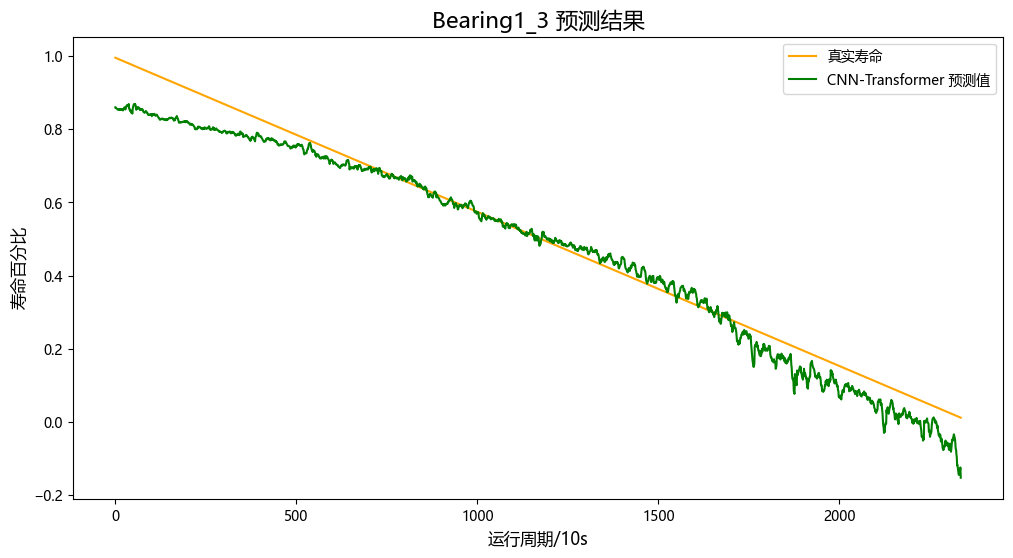

['../画图对比/cnn_transformer_pre']

In [11]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("font", family='Microsoft YaHei')

# 可视化结果
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test_origin_data, label='真实寿命',color='orange')  # 真实值
plt.plot(test__pre_data, label='CNN-Transformer 预测值',color='green')  # 预测值

# plt.plot([-1,170],[2.0*0.7,2.0*0.7],c='black',lw=1,ls='--')  # 临界点直线  可自己调整位置

plt.xlabel('运行周期/10s', fontsize=12)
plt.ylabel('寿命百分比', fontsize=12)
plt.title('Bearing1_3 预测结果', fontsize=16)
plt.legend()
plt.show()

# 保存数据
# 保存数据
dump(test_origin_data, '../画图对比/cnn_transformer_origin') 
dump(test__pre_data, '../画图对比/cnn_transformer_pre') 